In [1]:
import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\meiryo.ttc'  # 日本語フォント（メイリオ）のパス
font_prop = fm.FontProperties(fname=font_path)
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist

Epoch 1/50
469/469 [==============================] - 7s 10ms/step - loss: 0.2648 - val_loss: 0.2139
Epoch 2/50
469/469 [==============================] - 4s 9ms/step - loss: 0.2074 - val_loss: 0.2021
Epoch 3/50
469/469 [==============================] - 4s 9ms/step - loss: 0.2013 - val_loss: 0.2000
Epoch 4/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1988 - val_loss: 0.1969
Epoch 5/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1970 - val_loss: 0.1969
Epoch 6/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1958 - val_loss: 0.1952
Epoch 7/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1946 - val_loss: 0.1932
Epoch 8/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1936 - val_loss: 0.1931
Epoch 9/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1928 - val_loss: 0.1924
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.1922 - val_loss: 0.192

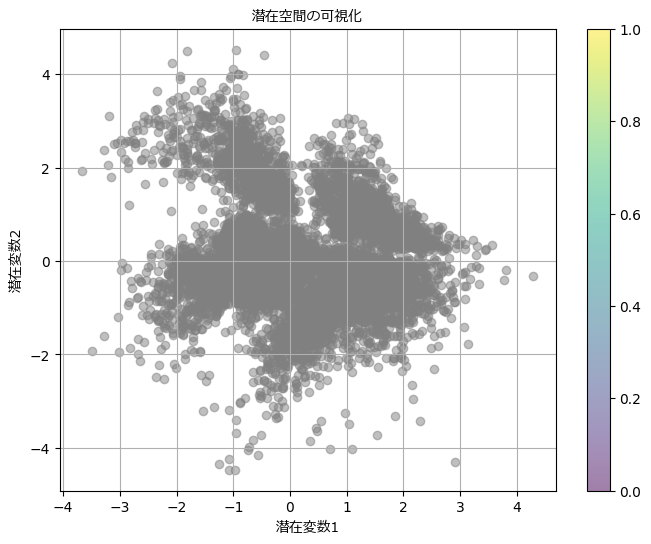

1/1 [==============================] - 0s 17ms/step


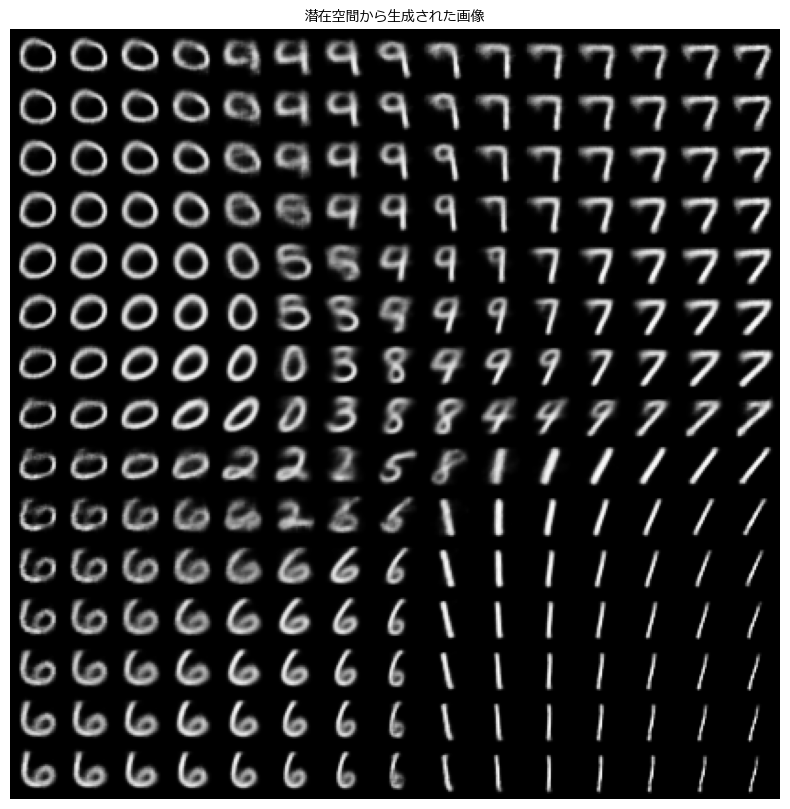

In [3]:
# データセットの読み込み
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# VAEの構築
latent_dim = 2

def sampling(args):
    """潜在変数のサンプリング関数"""
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# エンコーダ
input_img = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')

# デコーダ
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded_img = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, decoded_img, name='decoder')

# VAEモデル
outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')

# 損失関数の定義


def vae_loss(input_img, outputs):
    reconstruction_loss = tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(input_img, outputs)
    )
    reconstruction_loss *= 28 * 28
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return tf.reduce_mean(reconstruction_loss + kl_loss)


# 損失関数をカスタムレイヤー内に移動
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, kl_weight=0.001, **kwargs):
        super().__init__(**kwargs)
        self.kl_weight = kl_weight

    def call(self, inputs):
        input_img, outputs, z_mean, z_log_var = inputs
        # 再構成損失
        reconstruction_loss = tf.keras.losses.binary_crossentropy(
            tf.keras.backend.flatten(input_img),
            tf.keras.backend.flatten(outputs)
        )
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)

        # KLダイバージェンス損失
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        # 合計損失
        total_loss = reconstruction_loss + self.kl_weight * kl_loss
        self.add_loss(total_loss)
        return outputs


# VAEモデルの構築
vae_outputs = VAELossLayer(kl_weight=0.001)([input_img, outputs, z_mean, z_log_var])
vae = Model(input_img, vae_outputs, name="vae")
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

vae.fit(
    x_train, x_train,
    epochs=50,  # エポック数を増加
    batch_size=128,
    validation_data=(x_test, x_test)
)




# 学習
vae.fit(x_train, x_train, epochs=20, batch_size=128, validation_data=(x_test, x_test))

# 潜在空間の可視化
z_mean, _, _ = encoder.predict(x_test)
plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c='gray', alpha=0.5)
plt.colorbar()
plt.title('潜在空間の可視化', fontproperties=font_prop)
plt.xlabel('潜在変数1', fontproperties=font_prop)
plt.ylabel('潜在変数2', fontproperties=font_prop)
plt.grid()
plt.show()

# 潜在空間から画像を生成
n = 15  # グリッドサイズ
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

figure = np.zeros((28 * n, 28 * n))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.title('潜在空間から生成された画像', fontproperties=font_prop)
plt.axis('off')
plt.show()